In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(scene_stats_df='')
scene_stats_df = data_frames_list['scene_stats_df']

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/scene_stats_df.pkl.



# Visualize File Demographics

In [4]:

def visualize_scene_stats_scatter_plots(
    x_name, y_name, c_name='measure_of_right_ordering', x_description=None, y_description=None, c_description=None, mask_series=None,
    integer_to_string_dict=None, df=scene_stats_df, verbose=False
):
    continuous_threshold = 3
    if x_description is None: x_description = ' '.join([w.title() for w in x_name.split('_')])
    if y_description is None: y_description = ' '.join([w.title() for w in y_name.split('_')])
    legend_title = ' '.join([w.title() for w in c_name.split('_')])
    if isinstance(c_description, list): title_str = f'Scatter Plot of {x_description} vs {y_description} Colored by ' + legend_title
    elif (c_description is None): c_description = legend_title
    if not isinstance(c_description, list): title_str = f'Scatter Plot of {x_description} vs {y_description} Colored by {c_description}'
    
    # Create the scatter plot (mappable object)
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.cm.coolwarm
    if mask_series is None: mask_series = ~df[x_name].isnull() & ~df[y_name].isnull()
    x_series = df.sort_values(c_name)[mask_series][x_name]
    y_series = df.sort_values(c_name)[mask_series][y_name]
    c_series = df.sort_values(c_name)[mask_series][c_name]
    
    # Configure the color dictionary
    if isinstance(c_description, list) or ((integer_to_string_dict is not None) and (c_series.unique().shape[0] < continuous_threshold)):
        color_cycler = nu.get_color_cycler(c_series.unique().shape[0])
        face_color_dict = {}
        for c_category, fc_dict in zip(c_series.unique(), color_cycler()): face_color_dict[str(c_category)] = fc_dict['color']
        if verbose: print(face_color_dict)
        reshape_tuple = (1, -1)
    
    if isinstance(c_description, list):
        for c_category, category_description in zip(c_series.unique(), c_description):
            if verbose: print(c_category, category_description)
            c_mask = (df[c_name] == c_category)
            color = face_color_dict[str(c_category)].reshape(reshape_tuple)
            scatter = ax.scatter(x_series[c_mask], y_series[c_mask], color=color, alpha=0.75, label=category_description)
    elif (integer_to_string_dict is not None) and (c_series.unique().shape[0] < continuous_threshold):
        for c_category in c_series.unique():
            c_mask = (df[c_name] == c_category)
            category_description = integer_to_string_dict.get(c_category, c_category)
            color = face_color_dict[str(c_category)].reshape(reshape_tuple)
            scatter = ax.scatter(x_series[c_mask], y_series[c_mask], color=color, alpha=0.75, label=category_description)
    else: scatter = ax.scatter(x_series, y_series, c=c_series, cmap=cmap, alpha=0.75)
    
    # Add labels and title
    ax.set_xlabel(x_description)
    ax.set_ylabel(y_description)
    ax.set_title(title_str.replace(' Category', ''))
    
    # Add the colorbar and set its tick labels if dictionary available
    if verbose:
        print(f'(not isinstance(c_description, list)) = {bool(not isinstance(c_description, list))}')
        print(
            f'(c_series.unique().shape[0] >= continuous_threshold) = ({c_series.unique().shape[0]} >= {continuous_threshold})'
            f' = {bool(c_series.unique().shape[0] >= continuous_threshold)}'
        )
    if (not isinstance(c_description, list)) and (c_series.unique().shape[0] >= continuous_threshold):
        colorbar = plt.colorbar(scatter, label=legend_title)  # Use the scatter object as the mappable
        if (integer_to_string_dict is not None):
            positions = colorbar.get_ticks()
            labels = [integer_to_string_dict.get(p, round(p, 1)) for p in positions]
            colorbar.set_ticks(positions, labels=labels)
    else: ax.legend(title=legend_title.replace(' Category', ''), loc='lower right')
    
    # Annotate with Spearman's Rank Correlation Coefficient
    s_str = nu.get_spearman_rho_value_latex(x_series, y_series)
    y = 0.9
    if not ('=nan' in s_str):
        text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
        y -= 0.05
    
    # Annotate with Coefficient of Determination
    s_str = nu.get_r_squared_value_latex(x_series, y_series)
    text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
    
    return ax


## Color by demographic columns

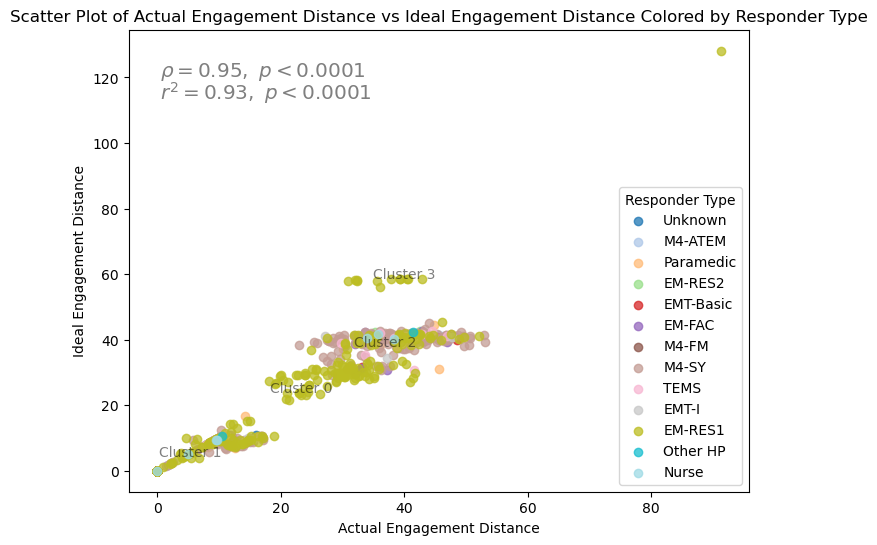

In [14]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'responder_type_category'
mask_series = ~scene_stats_df.responder_type.isnull()
_, string_to_integer_dict = nu.convert_strings_to_integers(scene_stats_df[mask_series].responder_type)
scene_stats_df[c_name] = scene_stats_df.responder_type.map(lambda x: string_to_integer_dict.get(x, np.nan))
integer_to_string_dict = {v: k for k, v in string_to_integer_dict.items()}
c_description = [k for k, v in string_to_integer_dict.items()]
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, c_description=c_description, integer_to_string_dict=integer_to_string_dict, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
centroids_list = []
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    centroids_list.append(centroid)
for i, centroid in enumerate(centroids_list):ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

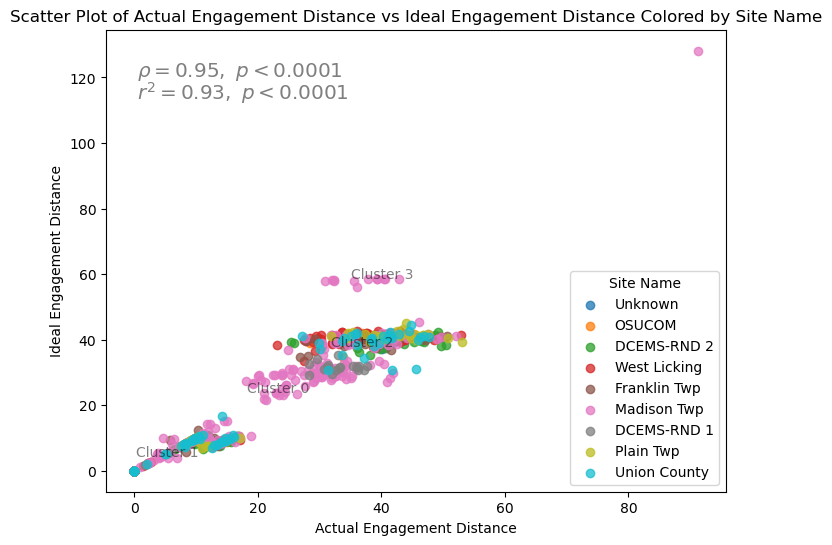

In [15]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'site_name_category'
mask_series = ~scene_stats_df.site_name.isnull()
_, string_to_integer_dict = nu.convert_strings_to_integers(scene_stats_df[mask_series].site_name)
scene_stats_df[c_name] = scene_stats_df.site_name.map(lambda x: string_to_integer_dict.get(x, np.nan))
integer_to_string_dict = {v: k for k, v in string_to_integer_dict.items()}
c_description = [k for k, v in string_to_integer_dict.items()]
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, c_description=c_description, integer_to_string_dict=integer_to_string_dict, verbose=False)

# Annotate label centroids with cluster labels
for i, centroid in enumerate(centroids_list):ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

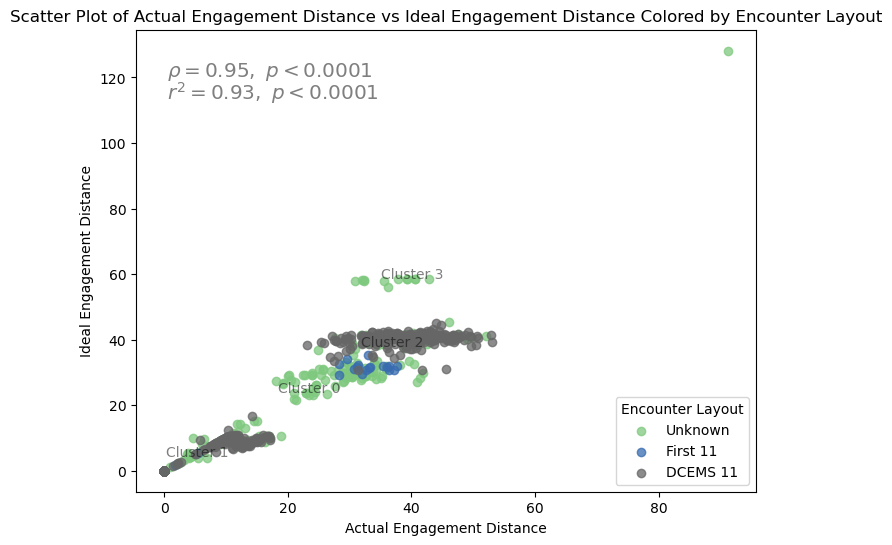

In [16]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'encounter_layout_category'
mask_series = ~scene_stats_df.encounter_layout.isnull()
_, string_to_integer_dict = nu.convert_strings_to_integers(scene_stats_df[mask_series].encounter_layout)
scene_stats_df[c_name] = scene_stats_df.encounter_layout.map(lambda x: string_to_integer_dict.get(x, np.nan))
integer_to_string_dict = {v: k for k, v in string_to_integer_dict.items()}
c_description = ['Unknown', 'First 11', 'DCEMS 11']
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, c_description=c_description, integer_to_string_dict=integer_to_string_dict, verbose=False)

# Annotate label centroids with cluster labels
for i, centroid in enumerate(centroids_list):ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)